In [17]:
import onnxruntime as rt
import cv2
import torch
import numpy as np
import os
import shutil
import imageio as imio
import matplotlib.pyplot as plt






In [47]:
vidos = "/vol2/KSH/NEW/KSH/DATASET_PROD/gis-kops/nng_tkrs_noyabrsk_srv01_camera_in_interesting_position-debug_case_24-08-18_20-01-25_20-01-55_null_cam13.mp4"
path_to_imgs = "/home/popovpe/Projects/WaterTrain/owl.guard.cv/cyclops/training/tkrs/tools/imgs/"
path_to_save = "/home/popovpe/Projects/WaterTrain/owl.guard.cv/cyclops/training/tkrs/tools/depth/"
DEPTH_ONNX_PATH = "/home/popovpe/Projects/WaterTrain/owl.guard.cv/cyclops/training/tkrs/tools/depth/depth.onnx"


In [15]:
depth_net = rt.InferenceSession(DEPTH_ONNX_PATH, providers=['CUDAExecutionProvider'])
depth_input_name = depth_net.get_inputs()[0].name
depth_label_name = depth_net.get_outputs()[0].name
depth_net.get_provider_options()
DEPTH_INFERENCE_SIZE = (686, 392)

def preprocess_for_depth(img_p):
    img = imio.imread(img_p)[..., :3]
    H, W, _ = img.shape
    img = cv2.resize(img, DEPTH_INFERENCE_SIZE)
    img = img.astype(np.float32) / 255.
    target_tensor = np.transpose(np.expand_dims(img, 0), [0, 3, 1, 2])

    return target_tensor, H, W

def inference_depth(img_p):
    target_tensor, H, W = preprocess_for_depth(img_p)
    
    depth = depth_net.run([depth_label_name], {depth_input_name: target_tensor})[0]
    depth = depth[0, ...]
    depth = np.transpose(depth, [1, 2, 0])[..., 0]
    depth = cv2.resize(depth, (W, H), cv2.INTER_CUBIC)

    return depth

2024-11-26 12:34:27.386604575 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-26 12:34:27.386617289 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


(1080, 1920, 3)


/tmp/ipykernel_288984/1275416835.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imio.imread(img_p)[..., :3]


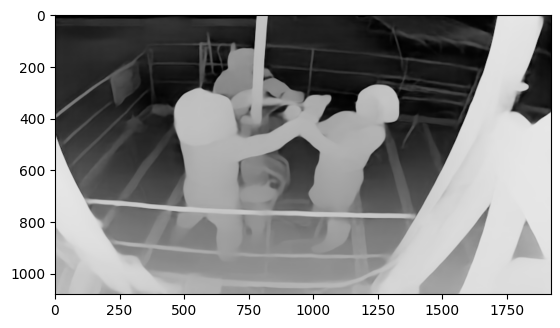

In [31]:
img_p = "/home/popovpe/Projects/WaterTrain/owl.guard.cv/cyclops/training/tkrs/tools/imgs/001.jpg"
depth = inference_depth(img_p)
depth = np.uint8(np.clip(1 - depth, 0, 1) * 255)
depth = np.dstack([depth, depth, depth])
print(depth.shape)
plt.imshow(depth)


In [22]:


for img_path in sorted(os.listdir(path_to_imgs)):
    
    # dif_img = np.zeros(shape=(640, 640*2, 3), dtype=np.uint8)
    # img = cv2.imread(path_to_imgs+img_path)
    # h, w, rgb = img.shape
    # ret = model(img[:, (w - h) // 2:(w + h) // 2, :], conf=0.25)
    # dif_img[:, 640:, :] = img
    depth = inference_depth(path_to_imgs+img_path)
    depth = np.uint8(np.clip(1 - depth, 0, 1) * 255)
    h, w = depth.shape

    depth = np.dstack([depth, depth, depth])
    depth = depth[:, (w - h) // 2:(w + h) // 2]
    cv2.imwrite(path_to_save+img_path, depth)
    
    

    


/tmp/ipykernel_288984/1275416835.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imio.imread(img_p)[..., :3]


## AVER DEPTH


0: 640x640 (no detections), 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5.7ms
Speed: 2.1ms preprocess, 5.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5.7ms
Speed: 2.1ms preprocess, 5.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5.2ms
Speed: 2.0ms preprocess, 5.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pipe_1_end, 5.4ms
Speed: 2.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pipe_1_end, 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pipe_1_end, 2 kopss, 1 kops_tros, 5.3ms
Speed: 2.2ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pipe_1_end, 1 kops, 1 kops_tros, 5.8ms
Speed: 2.8ms prep

/tmp/ipykernel_288984/1275416835.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imio.imread(img_p)[..., :3]


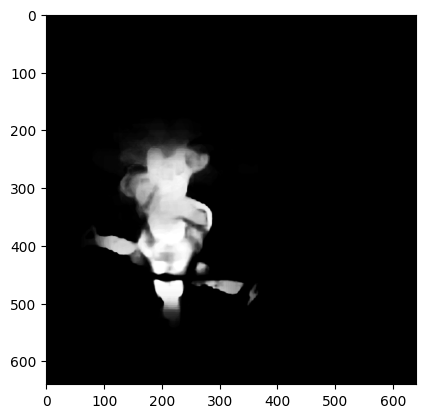

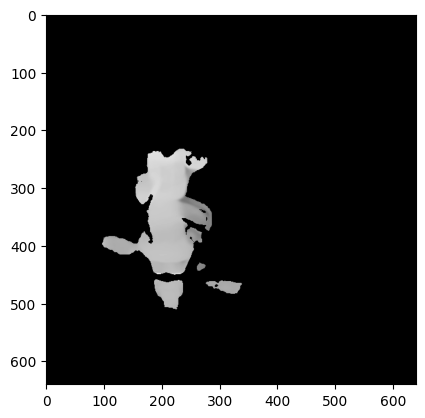

In [48]:

from ultralytics import YOLO
model = YOLO("/home/popovpe/.pyenv/runs/detect/proc/n_seg_19.11/best.pt")

n = 0
avg_mask = np.zeros(shape=(640, 640), dtype=int)
avg_depth = np.zeros(shape=(640, 640), dtype=int)

good_imgs = []
for img_path in sorted(os.listdir(path_to_imgs)):
    img = cv2.imread(path_to_imgs+img_path)
    #print(img)
    h, w, rgb = img.shape
    ret = model(img[:, (w - h) // 2:(w + h) // 2, :], conf=0.25)
    label = ret[0]
    annotated_frame = ret[0].plot()
    clss = label.boxes.cls.cpu().numpy().astype(dtype=int)
    confs = label.boxes.conf.cpu().numpy()
    xywh = label.boxes.xywh.cpu().numpy()

    for i, cls in enumerate(clss):
        if cls == 3:
            mask = ret[0].masks.data.cpu().numpy().astype(int).transpose(1, 2, 0)
            
            
            
            
            good_imgs.append(img_path)
            mask*=255
            avg_mask+=mask[:, :, i]
            n+=1
avg_mask//=n


inds = np.where(avg_mask > 127)
for img_path in good_imgs:
    depth = inference_depth(path_to_imgs+img_path)
    depth = np.uint8(np.clip(1 - depth, 0, 1) * 255)
    h, w = depth.shape

    depth = depth[:, (w - h) // 2:(w + h) // 2 ]
    depth = cv2.resize(depth, (640, 640), interpolation=cv2.INTER_CUBIC)
    avg_depth[inds] += depth[inds]
avg_depth//=n


#avg_depth = np.dstack([avg_depth, avg_depth, avg_depth])
cv2.imwrite(path_to_save+"avg_mask.jpg", np.uint8(avg_mask))
cv2.imwrite(path_to_save+"avg_depth.jpg", avg_depth.astype(np.uint8))
plt.imshow(avg_mask, cmap=plt.get_cmap('gray'))
plt.show()
plt.imshow(avg_depth, cmap=plt.get_cmap('gray'))
plt.show()

## DIF

In [72]:
mask = cv2.imread(path_to_save+"avg_mask.jpg")
aver_depth = cv2.imread(path_to_save+"avg_depth.jpg")[...,0] 
print(aver_depth.shape)
inds = np.where(mask > 127)[:2] #[:3]
print(max(inds[0]), min(inds[0]), max(inds[1]), min(inds[1]))

##inds = (223:520, 87:348, :)
for img_path in sorted(os.listdir(path_to_imgs)):
    dif_img = np.zeros(shape=(640, 640*3, 3), dtype=np.uint8)
    dif = np.zeros(shape=(640, 640), dtype=np.uint8)
    
    depth = inference_depth(path_to_imgs+img_path)
    depth = np.int16(np.clip(1 - depth, 0, 1) * 255)
    h, w = depth.shape

    depth = depth[:, (w - h) // 2:(w + h) // 2 ]
    depth = cv2.resize(depth, (640, 640), interpolation=cv2.INTER_CUBIC)
    dif[inds] = np.uint8(np.clip(depth[inds]-aver_depth.astype(np.int16)[inds], 0, 255))
    
    
    tr_inds = np.where(dif > 25)
    dif[:] = 0
    dif[tr_inds] = 255
    dif = cv2.blur(dif, (5, 5))
    score = (dif[inds]).sum()/len(inds)/1000000
    
    
    img = cv2.imread(path_to_imgs+img_path)
    h, w, rgb = img.shape
    img = img[:, (w - h) // 2:(w + h) // 2, :]
    img = cv2.resize(img, (640, 640), interpolation=cv2.INTER_CUBIC)
    dif_img[:, 640:640*2, :] = depth.reshape((640, 640, 1))
    dif_img[:, 640*2:, :] = img
    dif_img[:, :640,:] = dif.reshape((640, 640, 1))
    
    cv2.imwrite(path_to_save+"images_w_depth/"+img_path.replace(".jpg", f"_{score:.03f}.jpg"), dif_img)
#Image.open("/home/popovpe/Projects/WaterTrain/owl.guard.cv/cyclops/training/tkrs/tools/hsv/tmp.jpg")
#plt.imshow(img, ) #[:, :, :])

(640, 640)
510 233 338 97


/tmp/ipykernel_288984/1275416835.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imio.imread(img_p)[..., :3]
